# Building a Regression Model for the Price of Bitcoin

![](https://cdn.pixabay.com/photo/2018/02/02/13/51/bitcoin-3125488__180.png)

## The Data and Approach Taken in Choosing the Best Model
![](https://images.discordapp.net/avatars/475503071724568586/5e0dba0fcffdee0ed34be596907e7cdc.png?size=128)
<br>

* Data was obtained from kaggle and can be obatained at https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data
<br>

* The dataset consists of data from select bitcoin exchanges for the time period of Jan 2012 to March 2021, with minute to minute updates of OHLC (Open, High, Low, Close), Volume in BTC and indicated currency (USD), and weighted bitcoin price. 
<br>
* Financial technical analysis models are outside the scope of this notebook.
<br>
* The following notebook is structured as follows:
<br>
* -Data Cleaning: The dataset was explored via looking for missing data, outliers, feature distribution, etc.
<br>
* -Data Exploration: The dataset was explored to discover relationships and features. Both statistical and data visualization were used
<br>
* -Feature Engineering: Features were selected. The Target variable is "Close" and the independent variables are "Gap" (difference between the high & low price), "Volume_BTC", and "Volume_Currency".
<br>
* -Modeling: Models were built and tested both visually and statistically for goodness of fit

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import inf
import scipy
import scipy.stats as stats
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import shapiro
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.tsa.stattools import acf
import os
import warnings

warnings.filterwarnings('ignore')

df_bit = pd.read_csv(r'F:\DataSets\bitcoin\bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

[*********************100%%**********************]  1 of 1 completed


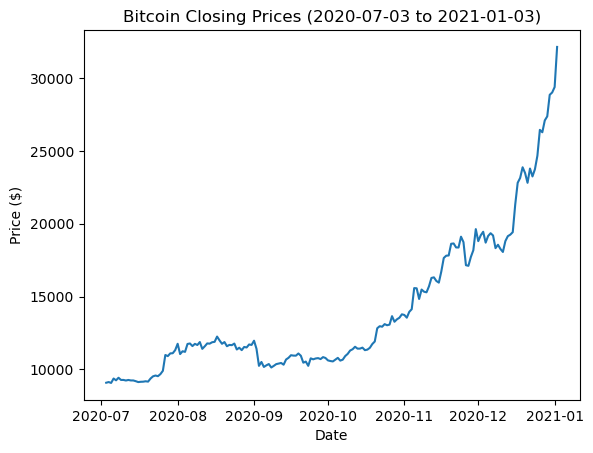

In [2]:
import yfinance as yf

tickerSymbol = 'BTC-USD'

start_date = '2020-07-03'
end_date = '2021-01-03'

btc_data = yf.download(tickerSymbol, start=start_date, end=end_date)

plt.plot(btc_data['Close'])
plt.title('Bitcoin Closing Prices ({} to {})'.format(start_date, end_date))
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

In [3]:
df_bit.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_bit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


In [5]:
df_bit.isnull().sum()

Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

In [6]:
round(df_bit.isnull().sum() * 100 / len(df_bit), 2)

Timestamp             0.0
Open                 25.6
High                 25.6
Low                  25.6
Close                25.6
Volume_(BTC)         25.6
Volume_(Currency)    25.6
Weighted_Price       25.6
dtype: float64

In [7]:
df_bit.shape

(4857377, 8)

In [8]:
df_bit.duplicated().sum()

0

![](https://i0.wp.com/vandalytic.com/wp-content/uploads/2020/02/Dirty-Data.jpg?resize=780%2C470&ssl=1)

* The initial data set consisted of 8 columns and 4,857,377 rows.
<br>

* ~ 26% of the data was missing. With that large of an amount of data missing it seemed prudent to drop them from the data set.  
<br>

* Some column names contained special characters, they were renamed to avoid any issues during data processing
<br>
* The timestamps were in Unix time, so the timestamps were converted to date time and the dataframe indexed via timestamp
<br>
* No duplicate values were found
<br>
* Due to the excessive amount of data and running on a local machine a six month time frame was chosen for this study: from 2020-07-03 00:00:00 to 2021-01-03 00:00:00
<br>
* The resulting data set contained 260,884 rows and 7 columns indexed by date time.

In [9]:
# Clean up column names

df_bit.columns 

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price'],
      dtype='object')

In [10]:
df_bit.rename(columns={'Volume_(BTC)':'Volume_BTC', 'Volume_(Currency)':'Volume_Currency'}, inplace=True)

In [11]:
df_bit.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_BTC',
       'Volume_Currency', 'Weighted_Price'],
      dtype='object')

In [12]:
# Dropping the rows with missing data values

df_bit.dropna(inplace=True)

In [13]:
df_bit.isnull().sum()

Timestamp          0
Open               0
High               0
Low                0
Close              0
Volume_BTC         0
Volume_Currency    0
Weighted_Price     0
dtype: int64

In [14]:
from datetime import datetime

df_bit['Timestamp'] = pd.to_datetime(df_bit['Timestamp'], unit='s')
df_bit.set_index(df_bit['Timestamp'], inplace=True)
df_bit.drop('Timestamp', axis=1, inplace=True)

In [15]:
df_bit.head()

,Open,High,Low,Close,Volume_BTC,Volume_Currency,Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
2011-12-31 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
2011-12-31 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
2012-01-01 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000


In [16]:
df_bit.shape

(3613769, 7)

In [17]:
start_date = pd.to_datetime('2020-07-03 00:00:00')
end_date = pd.to_datetime('2021-01-03 00:00:00')
df_bit = df_bit.loc[(df_bit.index>=start_date) & (df_bit.index<=end_date)]

df_bit.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260884 entries, 2020-07-03 00:00:00 to 2021-01-03 00:00:00
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Open             260884 non-null  float64
 1   High             260884 non-null  float64
 2   Low              260884 non-null  float64
 3   Close            260884 non-null  float64
 4   Volume_BTC       260884 non-null  float64
 5   Volume_Currency  260884 non-null  float64
 6   Weighted_Price   260884 non-null  float64
dtypes: float64(7)
memory usage: 15.9 MB


## Checking for Outliers

![](https://clipart-library.com/newhp/outlier2.jpg)

* The data was winsorized (capped) to remove outliers.
<br>

* All price variables were one-way winsorized by 5% of the highest value and volume variables were winzorized by 15% of the highest value which reduced the number of outliers to 0% determined using the IQR method.

![](https://miro.medium.com/v2/resize:fit:697/1*O3lOgPwuHP7Vfc1T6NDRrQ.png)

<br>


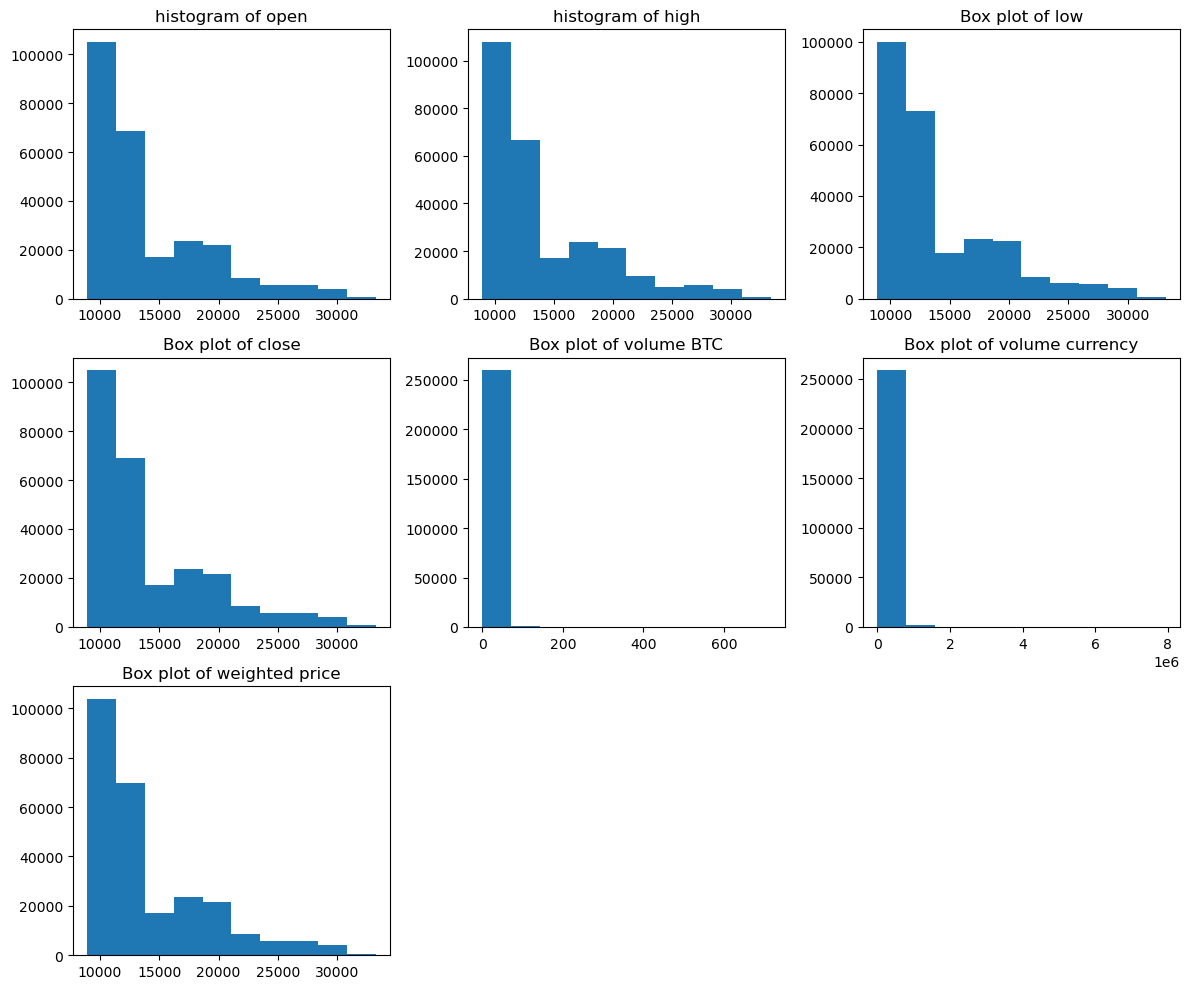

In [18]:
plt.figure(figsize = (12,10))

plt.subplot(3,3,1)
plt.hist(df_bit['Open'])
plt.title("histogram of open")

plt.subplot(3,3,2)
plt.hist(df_bit["High"])
plt.title("histogram of high")

plt.subplot(3,3,3)
plt.hist(df_bit["Low"])
plt.title("Box plot of low")

plt.subplot(3,3,4)
plt.hist(df_bit["Close"])
plt.title("Box plot of close")

plt.subplot(3,3,5)
plt.hist(df_bit["Volume_BTC"])
plt.title("Box plot of volume BTC")

plt.subplot(3,3,6)
plt.hist(df_bit["Volume_Currency"])
plt.title("Box plot of volume currency")

plt.subplot(3,3,7)
plt.hist(df_bit["Weighted_Price"])
plt.title('Box plot of weighted price')


plt.tight_layout()
plt.show()

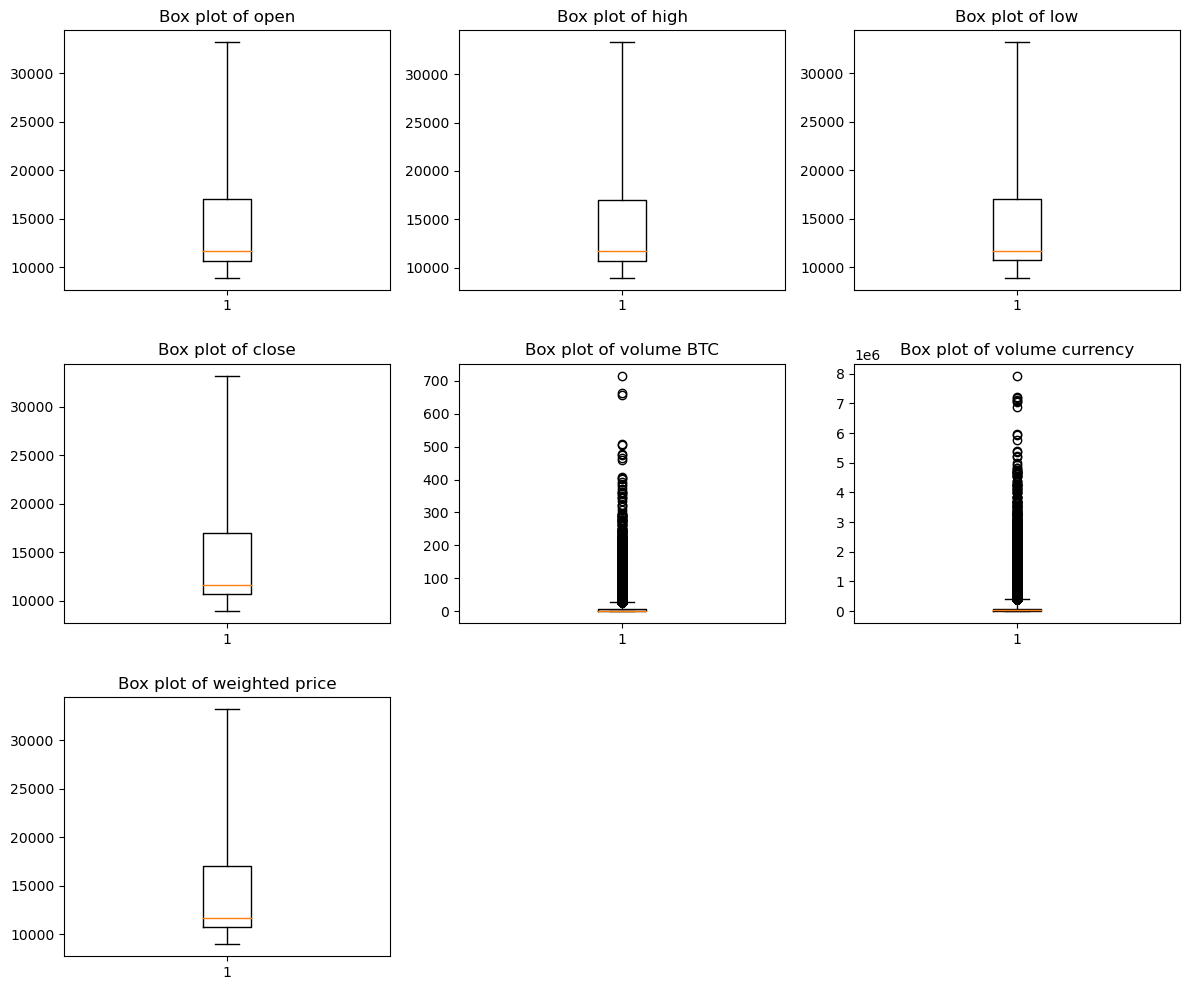

In [19]:
plt.figure(figsize = (12,10))

plt.subplot(3,3,1)
plt.boxplot(df_bit["Open"], whis = 5)
plt.title("Box plot of open")

plt.subplot(3,3,2)
plt.boxplot(df_bit["High"], whis = 5)
plt.title("Box plot of high")

plt.subplot(3,3,3)
plt.boxplot(df_bit["Low"], whis = 5)
plt.title("Box plot of low")

plt.subplot(3,3,4)
plt.boxplot(df_bit["Close"], whis = 5)
plt.title("Box plot of close")

plt.subplot(3,3,5)
plt.boxplot(df_bit["Volume_BTC"], whis = 5)
plt.title("Box plot of volume BTC")

plt.subplot(3,3,6)
plt.boxplot(df_bit["Volume_Currency"], whis = 5)
plt.title("Box plot of volume currency")

plt.subplot(3,3,7)
plt.boxplot(df_bit['Weighted_Price'], whis = 5)
plt.title('Box plot of weighted price')


plt.tight_layout()
plt.show()

In [20]:
list_of_columns = ['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_Currency', 'Weighted_Price']

for col in list_of_columns:
    q75, q25 = np.percentile(df_bit[col], [75 ,25])
    iqr = q75 - q25


    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)

    print("Number of outliers for {} is: {} and it is {} percent.".format(col, len((np.where((df_bit[col] > max_val) 
                      | (df_bit[col] < min_val))[0])), len((np.where((df_bit[col] > max_val) | 
                                                    (df_bit[col] < min_val))[0]))*100/3613769))

Number of outliers for Open is: 9554 and it is 0.2643777175574864 percent.
Number of outliers for High is: 9548 and it is 0.2642116859157295 percent.
Number of outliers for Low is: 9563 and it is 0.26462676502012167 percent.
Number of outliers for Close is: 9557 and it is 0.2644607333783648 percent.
Number of outliers for Volume_BTC is: 26322 and it is 0.7283808123872887 percent.
Number of outliers for Volume_Currency is: 27711 and it is 0.7668171374539988 percent.
Number of outliers for Weighted_Price is: 9540 and it is 0.26399031039338705 percent.


In [21]:
df_bit.describe()

,Open,High,Low,Close,Volume_BTC,Volume_Currency,Weighted_Price
count,260884.000000,260884.00000,260884.000000,260884.000000,260884.000000,2.608840e+05,260884.000000
mean,13947.636911,13954.69508,13940.706017,13947.889635,5.154283,7.641303e+04,13948.116946
std,4848.753313,4853.65963,4843.402228,4848.901639,12.548147,1.863334e+05,4848.507708
min,8943.780000,8956.99000,8905.000000,8940.300000,0.000005,5.654413e-02,8932.261335
25%,10697.767500,10700.67000,10694.570000,10697.810000,0.400000,4.909308e+03,10698.397751
50%,11678.225000,11682.99500,11674.560000,11678.400000,1.670159,2.267185e+04,11679.445760
75%,17025.785000,17037.16250,17014.167500,17026.465000,5.107992,7.389773e+04,17026.855372
max,33234.120000,33333.00000,33190.030000,33244.400000,716.184407,7.939944e+06,33252.149304


In [22]:
from scipy.stats.mstats import winsorize

winsorized_Open = winsorize(df_bit["Open"], (0.00, 0.05))
winsorized_High = winsorize(df_bit["High"], (0.00, 0.05))
winsorized_Low = winsorize(df_bit["Low"], (0.00, 0.05))
winsorized_Close = winsorize(df_bit["Close"], (0.00, 0.05))
winsorized_Volume_BTC = winsorize(df_bit["Volume_BTC"], (0.0, 0.15))
winsorized_Volume_Currency = winsorize(df_bit["Volume_Currency"], (0.0, 0.15))
winsorized_Weighted_Price = winsorize(df_bit["Weighted_Price"], (0.00, 0.05))

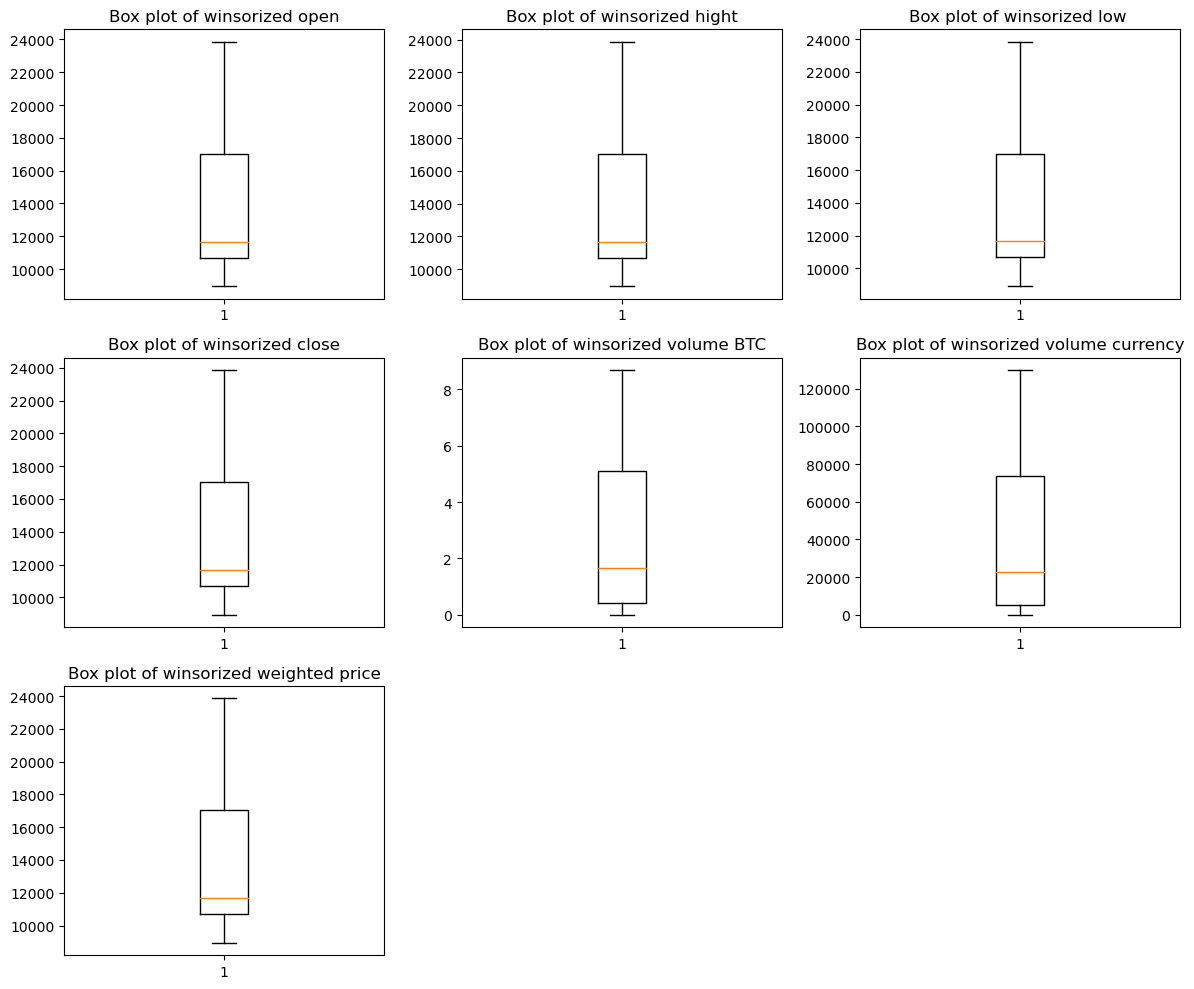

In [23]:
plt.figure(figsize = (12,10))

plt.subplot(3,3,1)
plt.boxplot(winsorized_Open, whis = 5)
plt.title("Box plot of winsorized open")

plt.subplot(3,3,2)
plt.boxplot(winsorized_High, whis = 5)
plt.title("Box plot of winsorized hight")

plt.subplot(3,3,3)
plt.boxplot(winsorized_Low, whis = 5)
plt.title("Box plot of winsorized low ")

plt.subplot(3,3,4)
plt.boxplot(winsorized_Close, whis = 5)
plt.title("Box plot of winsorized close")

plt.subplot(3,3,5)
plt.boxplot(winsorized_Volume_BTC, whis = 5)
plt.title("Box plot of winsorized volume BTC")

plt.subplot(3,3,6)
plt.boxplot(winsorized_Volume_Currency, whis = 5)
plt.title("Box plot of winsorized volume currency")

plt.subplot(3,3,7)
plt.boxplot(winsorized_Weighted_Price, whis = 5)
plt.title('Box plot of winsorized weighted price')


plt.tight_layout()
plt.show()

In [24]:
df_bit['Open'] = winsorized_Open
df_bit['High'] = winsorized_High
df_bit['Low'] = winsorized_Low
df_bit['Close'] = winsorized_Close
df_bit['Volume_BTC'] = winsorized_Volume_BTC
df_bit['Volume_Currency'] = winsorized_Volume_Currency
df_bit['Weighted_Price'] = winsorized_Weighted_Price

df_w = df_bit[['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_Currency', 'Weighted_Price']]

In [25]:
list_of_columns = ['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_Currency', 'Weighted_Price']

for col in list_of_columns:
    q75, q25 = np.percentile(df_w[col], [75 ,25])
    iqr = q75 - q25


    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)

    print("Number of outliers for {} is: {} and it is {} percent.".format(col, len((np.where((df_w[col] > max_val) 
                      | (df_w[col] < min_val))[0])), len((np.where((df_w[col] > max_val) | 
                                                    (df_w[col] < min_val))[0]))*100/3613769))

Number of outliers for Open is: 0 and it is 0.0 percent.
Number of outliers for High is: 0 and it is 0.0 percent.
Number of outliers for Low is: 0 and it is 0.0 percent.
Number of outliers for Close is: 0 and it is 0.0 percent.
Number of outliers for Volume_BTC is: 0 and it is 0.0 percent.
Number of outliers for Volume_Currency is: 0 and it is 0.0 percent.
Number of outliers for Weighted_Price is: 0 and it is 0.0 percent.


In [26]:
df_w.describe()

,Open,High,Low,Close,Volume_BTC,Volume_Currency,Weighted_Price
count,260884.000000,260884.000000,260884.000000,260884.000000,260884.000000,260884.000000,260884.000000
mean,13768.884104,13775.585577,13762.255883,13769.136975,3.003510,43608.259380,13769.299170
std,4369.160805,4373.109690,4364.657554,4369.283770,3.113869,46815.989900,4368.762214
min,8943.780000,8956.990000,8905.000000,8940.300000,0.000005,0.056544,8932.261335
25%,10697.767500,10700.670000,10694.570000,10697.810000,0.400000,4909.308379,10698.397751
50%,11678.225000,11682.995000,11674.560000,11678.400000,1.670159,22671.848013,11679.445760
75%,17025.785000,17037.162500,17014.167500,17026.465000,5.107992,73897.733014,17026.855372
max,23867.000000,23881.150000,23850.680000,23868.010000,8.692327,129971.407910,23865.628677


##  Checking Distribution of Features

![](https://i.ytimg.com/vi/-PwugYB9Zjs/hqdefault.jpg)

* Visually the features were right skewed (positive) with a trimodal appearance for the price variable and a bimodal appearance for the volume variables.
<br>

* None of the indicators were statistically normally distributed (all p values are < 0.05) based on the Jarque-Bera & Shapiro-Wilk test
<br>
* Several methods of transformation were evaluated however none were able to produce a Gaussian (Normal) distribution of data. I chose to stay with the winsorized data because of the clear right skew and that it's financial data it's more appropriate to obtain the performance estimations based on skewness.
<br>

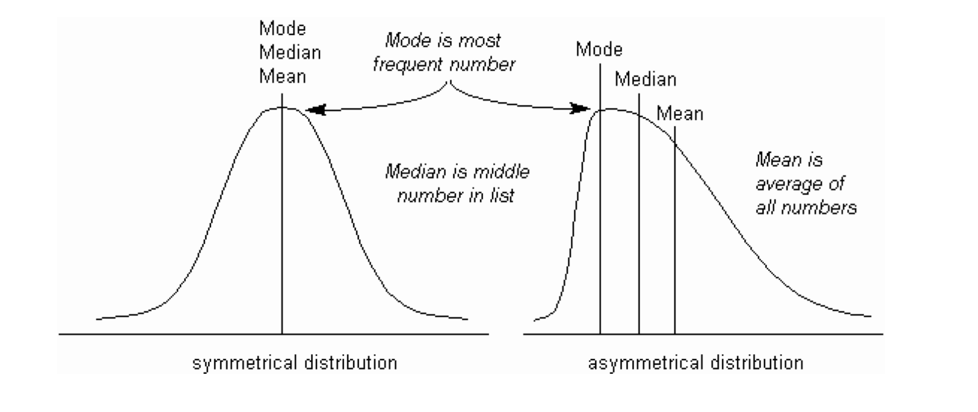

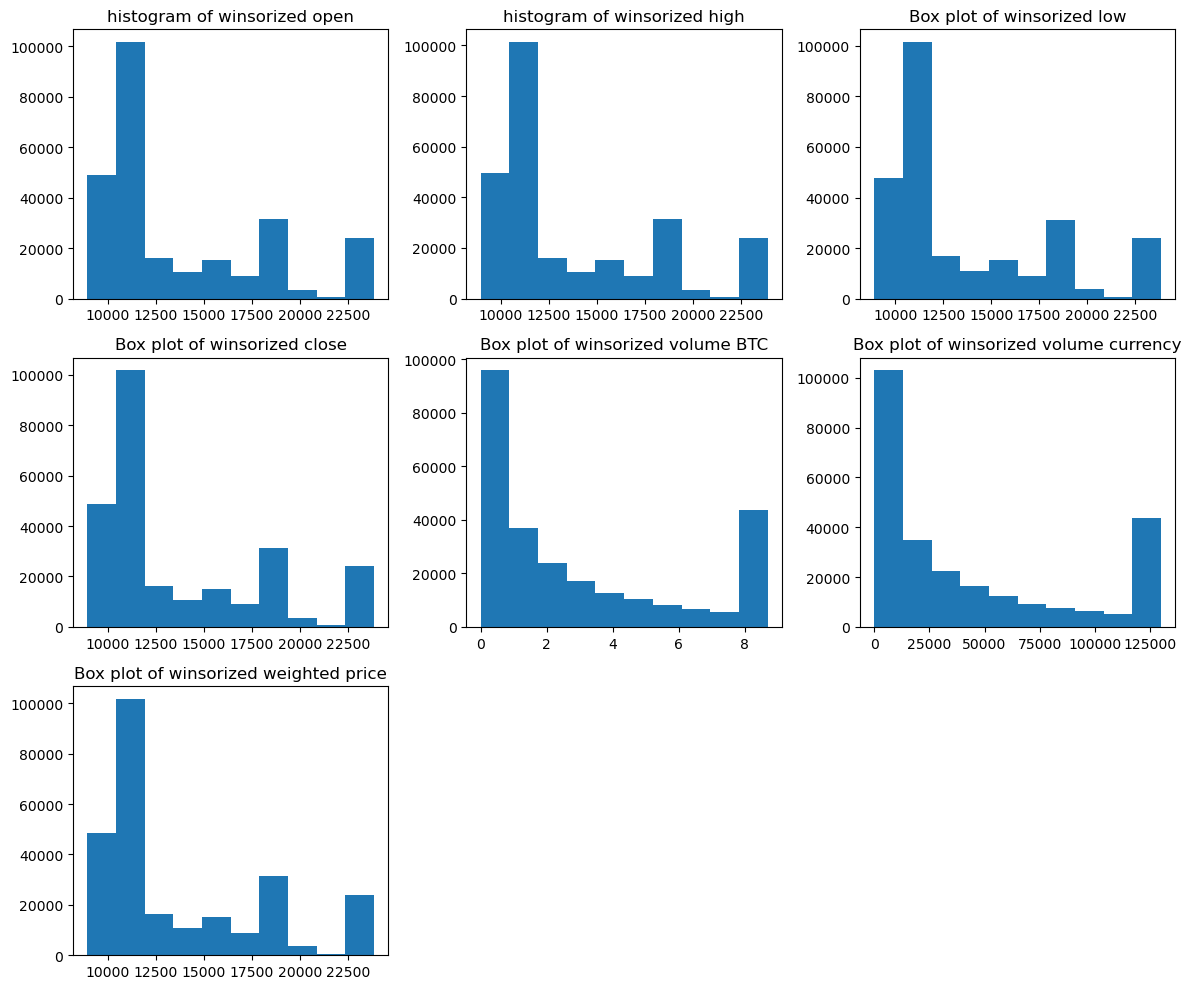

In [27]:
plt.figure(figsize = (12,10))

plt.subplot(3,3,1)
plt.hist(df_w['Open'])
plt.title("histogram of winsorized open")

plt.subplot(3,3,2)
plt.hist(df_w["High"])
plt.title("histogram of winsorized high")

plt.subplot(3,3,3)
plt.hist(df_w["Low"])
plt.title("Box plot of winsorized low")

plt.subplot(3,3,4)
plt.hist(df_w["Close"])
plt.title("Box plot of winsorized close")

plt.subplot(3,3,5)
plt.hist(df_w["Volume_BTC"])
plt.title("Box plot of winsorized volume BTC")

plt.subplot(3,3,6)
plt.hist(df_w["Volume_Currency"])
plt.title("Box plot of winsorized volume currency")

plt.subplot(3,3,7)
plt.hist(df_w["Weighted_Price"])
plt.title('Box plot of winsorized weighted price')


plt.tight_layout()
plt.show()

In [28]:
jb_stats = jarque_bera(df_w["Open"])
norm_stats = normaltest(df_w["Open"])

print("prices Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("prices Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(df_w["High"])
norm_stats = normaltest(df_w["High"])

print("market_caps Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("market_caps Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(df_w["Low"])
norm_stats = normaltest(df_w["Low"])

print("total_volumes Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("total_volumes Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(df_w["Close"])
norm_stats = normaltest(df_w["Close"])

print("prices Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("prices Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(df_w["Volume_BTC"])
norm_stats = normaltest(df_w["Volume_BTC"])

print("market_caps Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("market_caps Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(df_w["Volume_Currency"])
norm_stats = normaltest(df_w["Volume_Currency"])

print("total_volumes Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("total_volumes Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(df_w["Weighted_Price"])
norm_stats = normaltest(df_w["Weighted_Price"])

print("total_volumes Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("total_volumes Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

prices Jarque-Bera test statistics is 47690.44334579525 and p value is 0.0
prices Normality test statistics is 33155.178816695625 and p value is 0.0
market_caps Jarque-Bera test statistics is 47685.24702725925 and p value is 0.0
market_caps Normality test statistics is 33152.869497268926 and p value is 0.0
total_volumes Jarque-Bera test statistics is 47684.24853560652 and p value is 0.0
total_volumes Normality test statistics is 33152.17643635312 and p value is 0.0
prices Jarque-Bera test statistics is 47692.37699041533 and p value is 0.0
prices Normality test statistics is 33155.9925833415 and p value is 0.0
market_caps Jarque-Bera test statistics is 37820.55431988369 and p value is 0.0
market_caps Normality test statistics is 45674.73093092117 and p value is 0.0
total_volumes Jarque-Bera test statistics is 40022.273123157116 and p value is 0.0
total_volumes Normality test statistics is 42592.322491793035 and p value is 0.0
total_volumes Jarque-Bera test statistics is 47680.2407734933

In [29]:
scipy.stats.shapiro(df_w['Open'])
print(shapiro(df_w['Open']))

scipy.stats.shapiro(df_w['High'])
print(shapiro(df_w['High']))

scipy.stats.shapiro(df_w['Low'])
print(shapiro(df_w['Low']))

scipy.stats.shapiro(df_w['Close'])
print(shapiro(df_w['Close']))

scipy.stats.shapiro(df_w['Volume_BTC'])
print(shapiro(df_w['Volume_BTC']))

scipy.stats.shapiro(df_w['Volume_Currency'])
print(shapiro(df_w['Volume_Currency']))

scipy.stats.shapiro(df_w['Weighted_Price'])
print(shapiro(df_w['Weighted_Price']))

ShapiroResult(statistic=0.8347246646881104, pvalue=0.0)
ShapiroResult(statistic=0.8340780735015869, pvalue=0.0)
ShapiroResult(statistic=0.8346061706542969, pvalue=0.0)
ShapiroResult(statistic=0.8346174955368042, pvalue=0.0)
ShapiroResult(statistic=0.8132675886154175, pvalue=0.0)
ShapiroResult(statistic=0.801228940486908, pvalue=0.0)
ShapiroResult(statistic=0.8343473672866821, pvalue=0.0)


In [30]:
# Trying several transformation methods on the Open & Volume_BTC column since all the price data & volume columns have a similar distributions respectively.

from scipy.stats import boxcox

open_w_box,_ = boxcox(df_w["Open"])
volume_btc_w_box,_ = boxcox(df_w['Volume_BTC'])

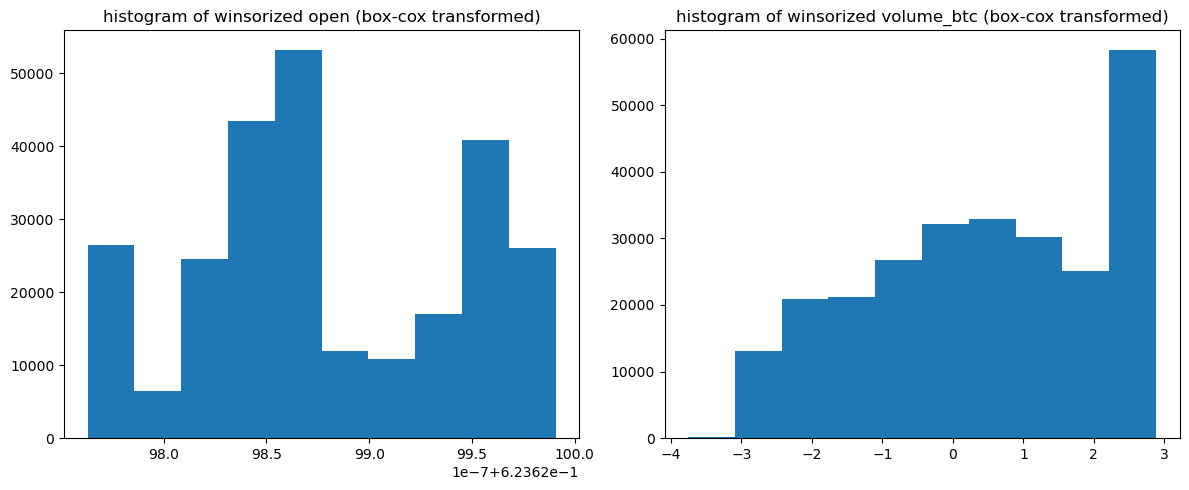

prices Jarque-Bera test statistics is 14194.24106799715 and p value is 0.0
prices Normality test statistics is 97193.62256982372 and p value is 0.0
************************************************************************************************
prices Jarque-Bera test statistics is 14194.24106799715 and p value is 0.0
prices Normality test statistics is 97193.62256982372 and p value is 0.0
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
ShapiroResult(statistic=0.9346998929977417, pvalue=0.0)
************************************************************************************************
ShapiroResult(statistic=0.943795382976532, pvalue=0.0)


In [31]:
plt.figure(figsize=(18,5))

# Histograms of the Box-Cox-transformed data
plt.subplot(1, 3, 1)
plt.hist(open_w_box)
plt.title("histogram of winsorized open (box-cox transformed)")

plt.subplot(1, 3, 2)
plt.hist(volume_btc_w_box)
plt.title("histogram of winsorized volume_btc (box-cox transformed)")

plt.tight_layout()
plt.show()

jb_stats = jarque_bera(open_w_box)
norm_stats = normaltest(open_w_box)
jb_stats = jarque_bera(volume_btc_w_box)
norm_stats = normaltest(volume_btc_w_box)

print("prices Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("prices Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))
print('************************************************************************************************')
print("prices Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("prices Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
scipy.stats.shapiro(open_w_box)
print(shapiro(open_w_box))
print('************************************************************************************************')
scipy.stats.shapiro(volume_btc_w_box)
print(shapiro(volume_btc_w_box))

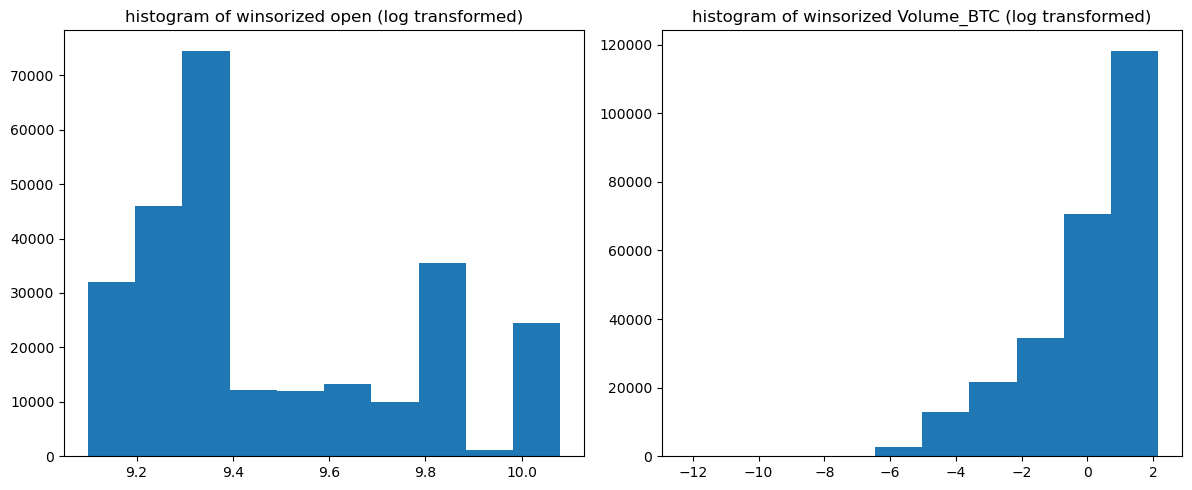

In [32]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(np.log(df_w['Open']))
plt.title('histogram of winsorized open (log transformed)')

plt.subplot(1,3,2)
plt.hist(np.log(df_w['Volume_BTC']))
plt.title('histogram of winsorized Volume_BTC (log transformed)')

plt.tight_layout()
plt.show()

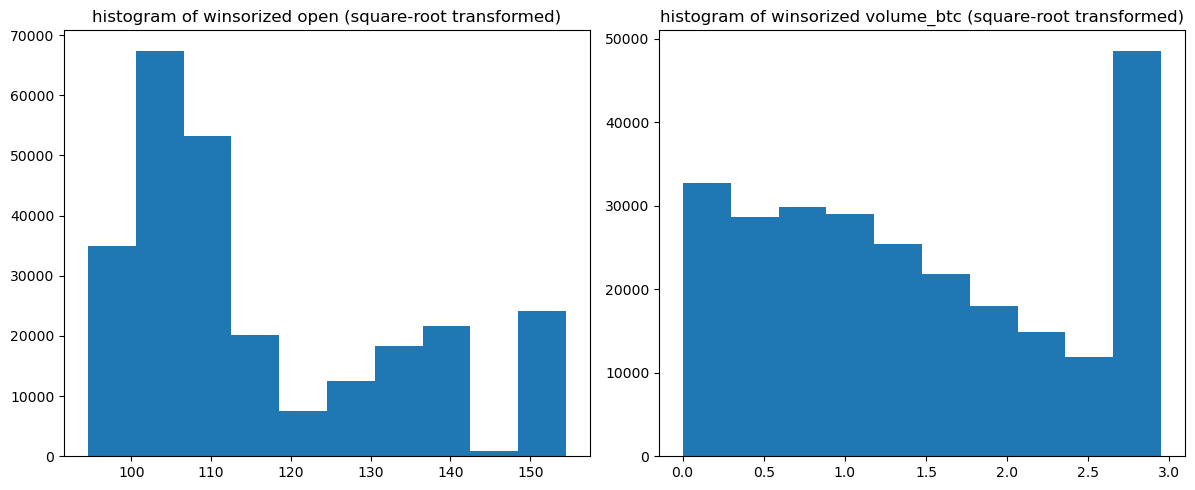

In [33]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(np.sqrt(df_w['Open']))
plt.title('histogram of winsorized open (square-root transformed)')

plt.subplot(1,3,2)
plt.hist(np.sqrt(df_w['Volume_BTC']))
plt.title('histogram of winsorized volume_btc (square-root transformed)')

plt.tight_layout()
plt.show()

In [34]:
del df_bit

# Data Exploration & Feature Engineering

<br>
* Determined the correlation of features and selected a Target variable and predictive variable/s

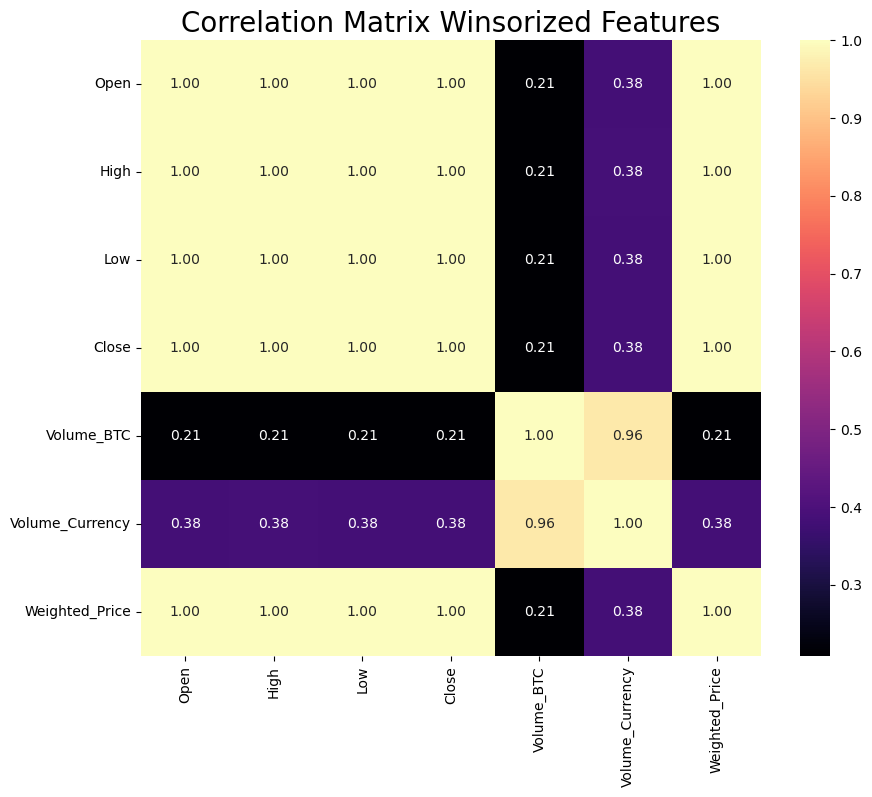

In [35]:
f, ax = plt.subplots(figsize=[10, 8])
sns.heatmap(df_w.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix Winsorized Features", fontsize=20)
plt.show()

In [36]:
df_w.corr()

,Open,High,Low,Close,Volume_BTC,Volume_Currency,Weighted_Price
Open,1.000000,0.999998,0.999997,0.999996,0.208882,0.384272,0.999998
High,0.999998,1.000000,0.999996,0.999998,0.209424,0.384785,0.999999
Low,0.999997,0.999996,1.000000,0.999998,0.208275,0.383692,0.999999
Close,0.999996,0.999998,0.999998,1.000000,0.208897,0.384286,0.999999
Volume_BTC,0.208882,0.209424,0.208275,0.208897,1.000000,0.964662,0.208826
Volume_Currency,0.384272,0.384785,0.383692,0.384286,0.964662,1.000000,0.384215
Weighted_Price,0.999998,0.999999,0.999999,0.999999,0.208826,0.384215,1.000000


In [37]:
df_w['Gap'] = df_w['High'] - df_w['Low']

In [38]:
df_w['Pivot_Point'] = df_w[['High', 'Low', 'Close']].mean(axis=1)

In [39]:
df_w['Bottom_Central_Pivot_Point'] = df_w[['High', 'Low']].mean(axis=1)

In [40]:
df_w['Top_Central_Pivot_Point'] = ((df_w['Pivot_Point'] - df_w['Bottom_Central_Pivot_Point']) + df_w['Pivot_Point'])

In [41]:
df_w.corr()

,Open,High,Low,Close,Volume_BTC,Volume_Currency,Weighted_Price,Gap,Pivot_Point,Bottom_Central_Pivot_Point,Top_Central_Pivot_Point
Open,1.000000,0.999998,0.999997,0.999996,0.208882,0.384272,0.999998,0.559093,0.999998,0.999999,0.999997
High,0.999998,1.000000,0.999996,0.999998,0.209424,0.384785,0.999999,0.560056,0.999999,0.999999,0.999998
Low,0.999997,0.999996,1.000000,0.999998,0.208275,0.383692,0.999999,0.557675,0.999999,0.999999,0.999998
Close,0.999996,0.999998,0.999998,1.000000,0.208897,0.384286,0.999999,0.558911,0.999999,0.999999,1.000000
Volume_BTC,0.208882,0.209424,0.208275,0.208897,1.000000,0.964662,0.208826,0.448753,0.208866,0.208851,0.208881
Volume_Currency,0.384272,0.384785,0.383692,0.384286,0.964662,1.000000,0.384215,0.530651,0.384255,0.384240,0.384270
Weighted_Price,0.999998,0.999999,0.999999,0.999999,0.208826,0.384215,1.000000,0.558864,1.000000,1.000000,0.999999
Gap,0.559093,0.560056,0.557675,0.558911,0.448753,0.530651,0.558864,1.000000,0.558882,0.558867,0.558896
Pivot_Point,0.999998,0.999999,0.999999,0.999999,0.208866,0.384255,1.000000,0.558882,1.000000,1.000000,1.000000
Bottom_Central_Pivot_Point,0.999999,0.999999,0.999999,0.999999,0.208851,0.384240,1.000000,0.558867,1.000000,1.000000,0.999999


* The data showed high multicolinearity between variables (Open, High, Low, and Weighted_Price)
<br>

* The variable Volume_BTC showed a low-level positive correlation with the target variable at 0.21 and no strong multicolinearity
<br>
* The variable Volume_Currency showed a low-level positive correlation with the target at 0.38 and no strong multicolinearity
<br>
* Feature engineering was used to create one other variable, "Gap" (High - Low) which had a mid-level positive correlation with the target at 0.56 and no strong multicolinearity
<br>
* The Target feature is "Close" and the independent features are "Volume_BTC", "Volume_Currency", and "Gap"

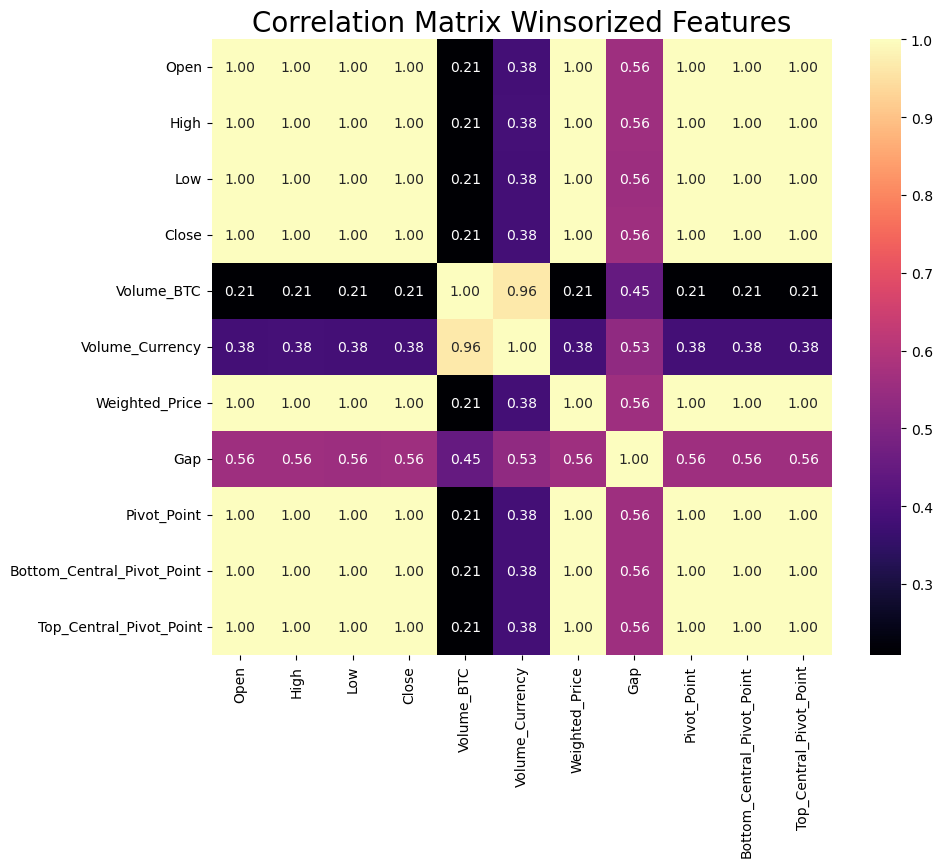

In [42]:
f, ax = plt.subplots(figsize=[10, 8])
sns.heatmap(df_w.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix Winsorized Features", fontsize=20)
plt.show()

In [43]:
df_w.drop(['Open', 'High', 'Low', 'Pivot_Point', 'Bottom_Central_Pivot_Point', 'Top_Central_Pivot_Point', 'Weighted_Price'], axis=1, inplace=True)

In [45]:
df_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260884 entries, 2020-07-03 00:00:00 to 2021-01-03 00:00:00
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Close            260884 non-null  float64
 1   Volume_BTC       260884 non-null  float64
 2   Volume_Currency  260884 non-null  float64
 3   Gap              260884 non-null  float64
dtypes: float64(4)
memory usage: 10.0 MB


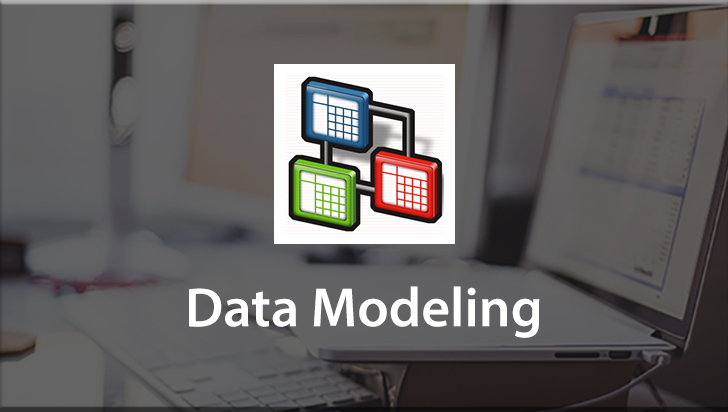


* Error - Actual value - Predicted value
<br>

* MAE - divide the sum of absolute errors by the number of predictions (ie The average difference between the predicted and actual prices)
<br>
* MSE - dividing the sum of squared errors by the number of predictions results in the Mean Squared Error (MSE), result is not in the same units as the value to predict.
<br>
* RMSE - square root of MSE, allows MSE value to make sense.
<br>
* MAPE - the mean of all absolute percentage errors between the predicted and actual values.
>* Not possible to use when actual values are close to 0 (due to division by actual)
>* MAPE = (1/n) * Σ(|actual – forecast| / |actual|) * 100
<br>
* Train test split - a model validation process that allows you to simulate how your model would perform with new data.
>* Performance evaluated on the test set
>* The slight difference in values seen between sets is the inheret variability of the data.

In [46]:
Y=df_w.iloc[:,0].values
X=df_w.iloc[:,1:].values

# Normalizing the data

scaler = StandardScaler()
X= scaler.fit_transform(X)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

The number of observations in training set is 208707
The number of observations in test set is 52177


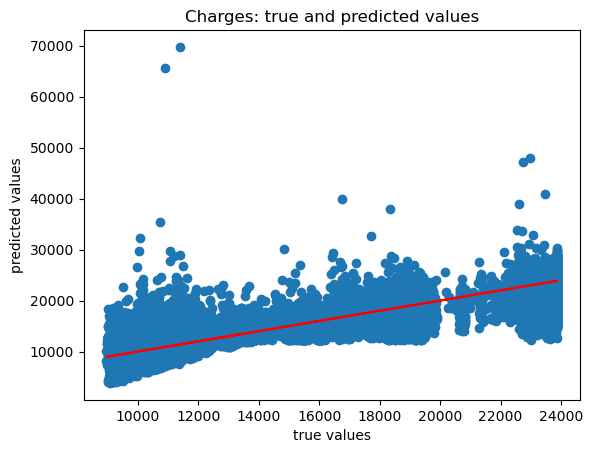

R-squared of the model in the training set is: 0.5888721789368272
-----Test set statistics-----
R-squared of the model in the test set is: 0.5950499990403482
Mean absolute error of the prediction is: 2111.12954532536
Mean squared error of the prediction is: 7795125.332726076
Root mean squared error of the prediction is: 2791.975166925035
Mean absolute percentage error of the prediction is: 15.592049612379514


In [48]:
# Linear regression

model = LinearRegression()


# Train the model
model.fit(X_train, y_train)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

    
# Make predictions and evalute
y_preds_train = model.predict(X_train)
y_preds_test = model.predict(X_test)
    
    
# Plot
plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()
    
    
print("R-squared of the model in the training set is: {}".format(model.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(model.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

In [49]:
## OLS

X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                 9.964e+04
Date:                Mon, 21 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:16:24   Log-Likelihood:            -1.9526e+06
No. Observations:              208707   AIC:                         3.905e+06
Df Residuals:                  208703   BIC:                         3.905e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.377e+04      6.126   2247.221      0.0

* KNN Models

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()
param_grid = {'n_neighbors': np.arange(5,50)}
grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X, Y)
print('Best parameters:', grid.best_params_)

Best parameters: {'n_neighbors': 7}


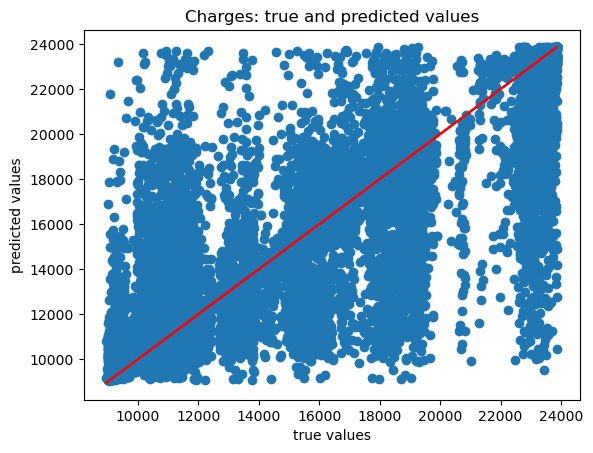

R-squared of the model in training set is: 0.971301805554308
-----Test set statistics-----
R-squared of the model in test set is: 0.883258876235964
Mean absolute error of the prediction is: 614.7600353386817
Mean squared error of the prediction is: 2247219.8766944027
Root mean squared error of the prediction is: 1499.073005792047
Mean absolute percentage error of the prediction is: 4.362101784214558


In [51]:
# Removing the column added to X_train as a constant for OLS
X_train = X_train[:,1:]

knn = KNeighborsRegressor(n_neighbors=7, weights='distance')

knn.fit(X_train, y_train)

y_preds_train = knn.predict(X_train)
y_preds_test = knn.predict(X_test)

# Plot
plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()


print("R-squared of the model in training set is: {}".format(knn.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(knn.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

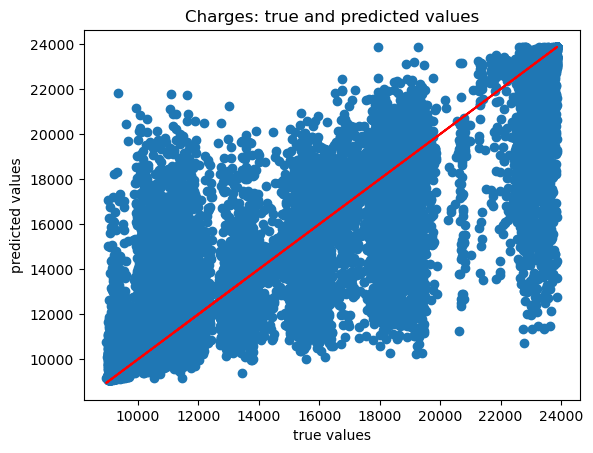

R-squared of the model in training set is: 0.9231563795751868
-----Test set statistics-----
R-squared of the model in test set is: 0.8960418909793283
Mean absolute error of the prediction is: 624.2680882107334
Mean squared error of the prediction is: 2001151.962585327
Root mean squared error of the prediction is: 1414.6207840214024
Mean absolute percentage error of the prediction is: 4.480585062285999


In [52]:
knn = KNeighborsRegressor(n_neighbors=7)

knn.fit(X_train, y_train)

y_preds_train = knn.predict(X_train)
y_preds_test = knn.predict(X_test)

# Plot
plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()


print("R-squared of the model in training set is: {}".format(knn.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(knn.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

* The above unweighted model generalizes the data better based on the difference of R2test < R2training to the weighted model

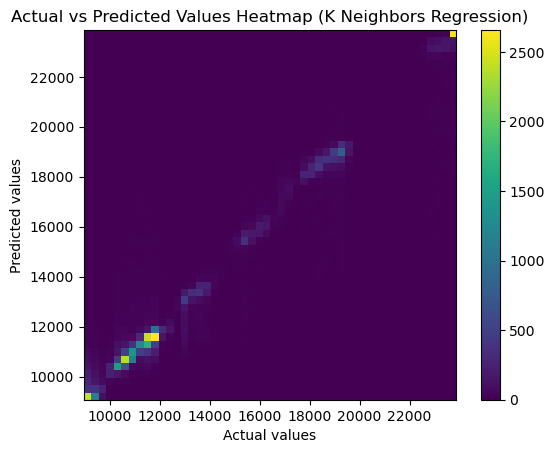

In [53]:
heatmap, xedges, yedges = np.histogram2d(y_test, y_preds_test, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted Values Heatmap (K Neighbors Regression)')
plt.colorbar()
plt.show()

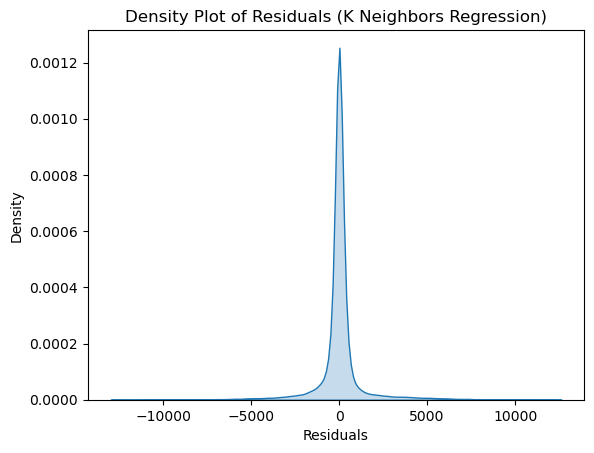

In [54]:
# Density of residuals plot. A normally distributed plot demonstrates the model is a good fit for the data.

residuals = y_test - y_preds_test

sns.kdeplot(residuals, shade=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Density Plot of Residuals (K Neighbors Regression)')
plt.show()

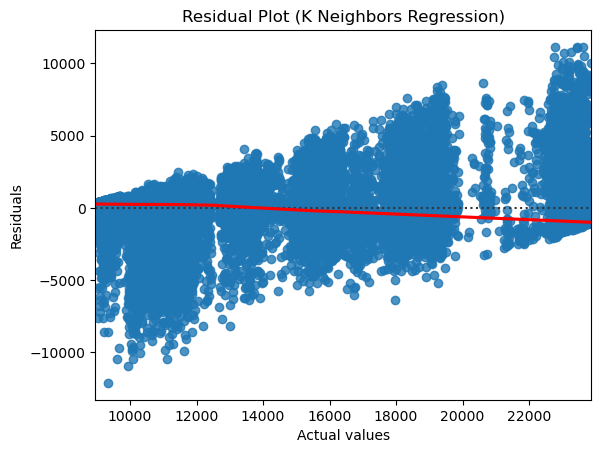

In [55]:
# Residual plot shows the difference between the actual target variable values and the predicted values. A good model would have a random scatter of residuals, centered around zero

residuals = y_test - y_preds_test
sns.residplot(x=y_test, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Actual values')
plt.ylabel('Residuals')
plt.title('Residual Plot (K Neighbors Regression)')
plt.show()

In [56]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score

# Cross validation of unweighted KNN model

knn = KNeighborsRegressor(n_neighbors=7)

kfold = KFold(n_splits=5, shuffle=True, random_state = 465)

cv_scores = cross_val_score(knn, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

mean_score = -np.mean(cv_scores)
std_score = np.std(cv_scores)
rmse = np.sqrt(mean_score)

print('CV mean squared error:', mean_score)
print('CV error standard deviation:', std_score)
print('CV root mean squared error:', rmse)

CV mean squared error: 2018680.4231328175
CV error standard deviation: 36261.0677076654
CV root mean squared error: 1420.8027389939878


* Graidient Boost Model

In [57]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor()

parameters = {'n_estimators': [100, 150, 200, 300],
              'learning_rate': [0.1, 1, 1.5]}

grid_search = GridSearchCV(gb_model, parameters, cv=5)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


Best hyperparameters: {'learning_rate': 1, 'n_estimators': 300}


In [58]:
score=r2_score(y_test, y_pred)

print("R2 score: {:.2f}".format(score))

R2 score: 0.91


In [59]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE): {:.2f}".format(mse))

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape*100))

Mean Squared Error (MSE): 1738600.64
Mean Absolute Percentage Error (MAPE): 4.69%


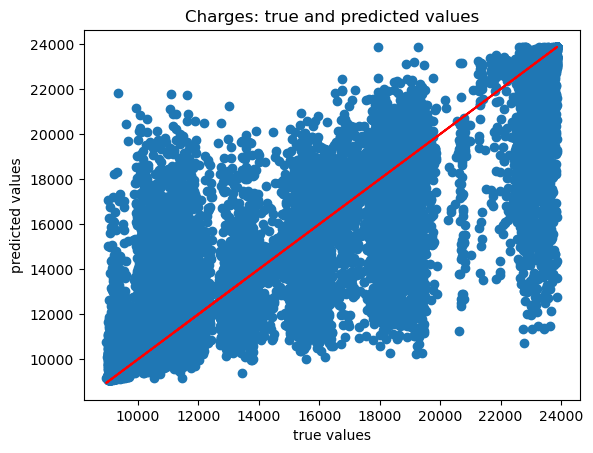

In [60]:
# Plot
plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

* Random Forest Reggression Model

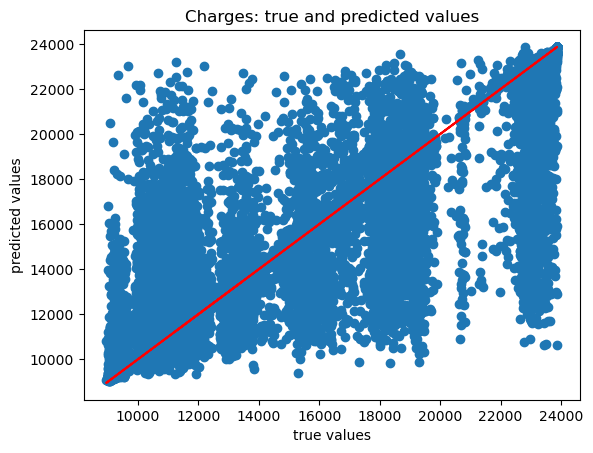

R-squared of the model in training set is: 0.9500794119211632
-----Test set statistics-----
R-squared of the model in test set is: 0.9008460861018546
Mean absolute error of the prediction is: 441.5528896840907
Mean squared error of the prediction is: 1908673.1305956584
Root mean squared error of the prediction is: 1381.5473682055417
Mean absolute percentage error of the prediction is: 3.059474450166651


In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

regressor = RandomForestRegressor(n_estimators=300, random_state=0)

regressor.fit(X_train, y_train)

y_preds_train = regressor.predict(X_train)
y_preds_test = regressor.predict(X_test)

# Plot
plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()


print("R-squared of the model in training set is: {}".format(regressor.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(regressor.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
mse_error = mean_squared_error(y_test, y_preds_test)
print("Mean squared error of the prediction is: {}".format(mse_error))
print("Root mean squared error of the prediction is: {}".format(np.sqrt(mse_error)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

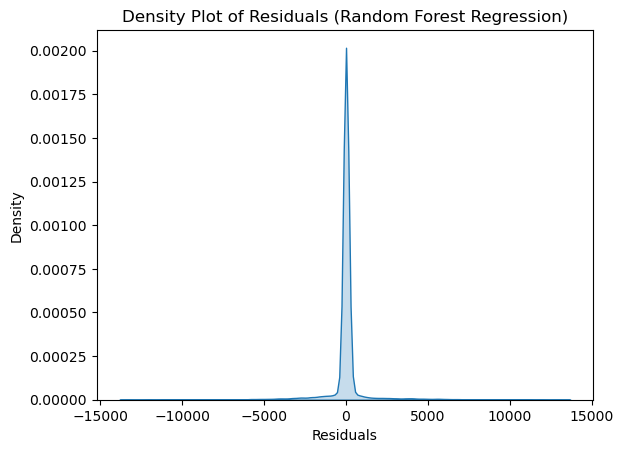

In [62]:
# Density of residuals plot. A normally distributed plot demonstrates the model is a good fit for the data.

residuals = y_test - y_preds_test

sns.kdeplot(residuals, shade=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Density Plot of Residuals (Random Forest Regression)')
plt.show()

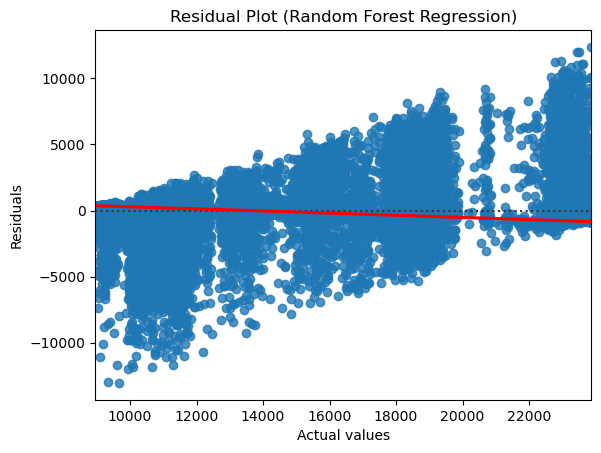

In [63]:
# Residual plot shows the difference between the actual target variable values and the predicted values. A good model would have a random scatter of residuals, centered around zero

residuals = y_test - y_preds_test
sns.residplot(x=y_test, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Actual values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Random Forest Regression)')
plt.show()

In [64]:
feature_importances = regressor.feature_importances_
print('Feature Importances:')
for i in range(len(feature_importances)):
    print('Feature %d: %f' % (i, feature_importances[i]))


Feature Importances:
Feature 0: 0.190978
Feature 1: 0.169722
Feature 2: 0.639301


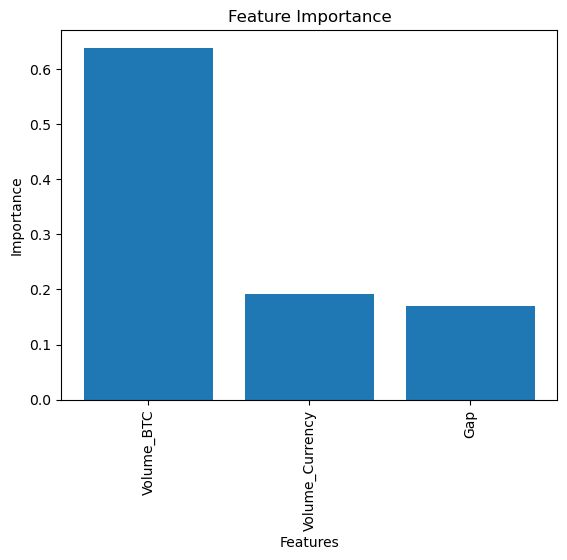

In [65]:
feature_names = ['Volume_BTC', 'Volume_Currency', 'Gap']

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[indices]

# feature importances
plt.figure()
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), sorted_feature_importances, align="center")
plt.xticks(range(X_train.shape[1]), feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [66]:
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=0)

# Perform k-fold cross-validation on the dataset
scores = cross_val_score(rf_regressor, X, Y, cv=5, scoring='neg_mean_squared_error')

# Print the mean and standard deviation of the scores
print("Mean cross-validation score: ", scores.mean())
print("Standard deviation of cross-validation score: ", scores.std())

Mean cross-validation score:  -5518436.693778381
Standard deviation of cross-validation score:  6969354.803335043


*  The CV score indicates overfitting is possibly occuring.

* Bagged_Regessor

In [67]:
from pycaret.regression import *

data = df_w
exp = setup(data, target='Close', normalize=True)

bagged_model = create_model('br')
evaluate_model(bagged_model)

,Description,Value
0,Session id,4682
1,Target,Close
2,Target type,Regression
3,Original data shape,"(260884, 4)"
4,Transformed data shape,"(260884, 4)"
5,Transformed train set shape,"(182618, 4)"
6,Transformed test set shape,"(78266, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2088.0459,7603548.5000,2757.4534,0.6001,0.1901,0.1548
1,2100.4536,7945680.0000,2818.8083,0.5786,0.1912,0.1554
2,2104.7920,7620015.0000,2760.4375,0.6002,0.1913,0.1560
3,2093.4236,7674283.0000,2770.2495,0.5947,0.1901,0.1544
4,2106.6335,7680285.0000,2771.3328,0.5934,0.1918,0.1567
5,2131.0352,8207927.5000,2864.9480,0.5740,0.1931,0.1569
6,2117.3130,7881330.0000,2807.3706,0.5917,0.1923,0.1561
7,2112.9590,7797442.5000,2792.3901,0.5931,0.1920,0.1556
8,2134.9812,7826308.5000,2797.5540,0.5889,0.1940,0.1584


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Results Summary
<br>

| Model | R^2 | MAE | MSE | RMSE | MAPE |
| :- | :- | :- | :- | :- | :- |
| Bagged Regressor | 0.59 | 2,123 | 7,898,903 | 2,810 | <mark>0.2%<mark> |
| Linear Regression | 0.60 | 2,111 | 7,795,125 | 2,792 | 15.6% |
| KNN | 0.90 | 624 | 2,001,152 | 1,415 | 4.5% |
| Graident Boost | <mark>0.91<mark> | N/A | <mark>1,738,679<mark> | N/A | 4.7% |
| Random Forest | 0.90 | <mark>442<mark> | 1,908,673 | <mark>1,382<mark> | 3.1% | 
<br>

* The Random Forest Regression model is the best fit for the data.
<br>
    
* The volume of Bitcoin was by far the feature of greatest importance ~0.6.
<br>
* Bitcoin is still such a volatile market with large price swings. This can be seen in the error values of the model.
<br>
* There is no fixed forecasting horizen with a Random Forest Regression model. I believe in the case of Bitcoin with 6 months worth of data on 1 minute timestamps a short-term horizen would be the prudent choice.
